The purpose of this notebook is to assess the performance of our models. 

In [11]:
# Package Imports

import math
import pandas as pd
import numpy as np
# import librosa
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.io import wavfile
from collections import OrderedDict
from tqdm import tqdm
import pickle
import json
import glob
import os
from os import path
import boto3
from PIL import Image
import json

import re
import json
import sagemaker
import glob
from sagemaker import get_execution_role, session
from scipy.io import wavfile

In [12]:
JSON_LINES_FILE = "annots.jsonl"
MODEL_OUTPUT_URL = "s3://sagemaker-us-west-2-959616474350/output"
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"
SPECTROGRAM_FILE_PATH = "spectrograms/"

In [13]:
# Establishing the SageMaker session and specifying the region in which the session is occurring
sm_session = sagemaker.Session()
region = sm_session.boto_region_name

# Specifying the training log channel
client = boto3.client("logs")


# Specifying the execution role to establish permissions for access purposes
role = get_execution_role()

runtime = boto3.client(service_name="runtime.sagemaker")

# Identifying the S3 bucket in which the model artifacts are located
s3 = boto3.resource('s3')
bucket = s3.Bucket('sagemaker-us-west-2-959616474350')

download_bucket = s3.Bucket('monitoring-whale-recordings')

In [14]:
from sagemaker.model import Model
from sagemaker import image_uris

# Function to obtain model artifacts given the folder name in the S3 bucket
def get_model_from_output(model_output_path):
    model_url = f"s3://sagemaker-us-west-2-959616474350/output/{model_output_path}/output/model.tar.gz"
    # Retrieves the URI to the object detection docker image
    image_uri = image_uris.retrieve(
        region=sm_session.boto_region_name, framework="object-detection", version="latest")

    model = Model(image_uri=image_uri, model_data=model_url, role=role)
    return model

In [48]:
from sagemaker.model_monitor import DataCaptureConfig

# Function to create a Sagemaker endpoint to host and deploy the model and obtain information
def deploy_model(model, endpoint_name):
    print("EndpointName={}".format(endpoint_name))
    
    try:
        data_capture_config = DataCaptureConfig(
        enable_capture=True, sampling_percentage=100, destination_s3_uri=MODEL_OUTPUT_URL)

        predictor = model.deploy(
            initial_instance_count=1,
            instance_type="ml.m4.xlarge",
            endpoint_name=endpoint_name,
            data_capture_config=data_capture_config,
        )
    except Exception as e:
        print(e)
        delete_model(model)
        return deploy_model()
    return predictor

# Function to delete endpoint
def delete_model(model):
    print(f"endpoint_name - {model.endpoint_name}")
    endpoint_config_name = re.sub("endpoint/", "endpoint-config/", model.endpoint_name)
    
    sagemaker.Session().delete_endpoint_config(model.endpoint_name)
    sagemaker.Session().delete_endpoint(model.endpoint_name)

    


In [16]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline



# Function to plot the mAP score over time against the epochs
def plot_object_detection_log(trained_model_name, title):
    estimator = sagemaker.estimator.Estimator.attach(trained_model_name)
    
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=estimator._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))



    fig, ax = plt.subplots()
    plt.xlabel("Number of Iterations Over the Entire \n Data Set During Model Training")
    plt.ylabel("Mean Avg Precision (mAP)")
    plt.suptitle(title, fontsize=14)
    plt.title("Maximum mAP: %f " % max(mAP_accs), fontsize=12)
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

In [17]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import time

def get_predictor(endpoint_name):
    predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())
    return predictor

In [18]:
def fetch_from_bucket(source_file_path, dest_file_name):
    bucket.download_file(source_file_path, dest_file_name)

In [19]:
#takes in the name of a file thats been locally downloaded and returns results
def get_model_bounding_boxes(spectrogram_name):
    try:
        with open(spectrogram_name, "rb") as image:
            f = image.read()
            b = bytearray(f)

            endpoint_response = runtime.invoke_endpoint(EndpointName=predictor.endpoint_name, ContentType="image/png", Body=b)
            results = endpoint_response["Body"].read()
            detections = json.loads(results)
    except Exception as e:
        print(e)
        return
    return sorted(detections["prediction"], key=lambda x:x[1], reverse=True)

In [20]:
# drawOriginal(filename)
from matplotlib.pyplot import figure
from time import sleep
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_hand_annotations(hand_annots, img_height, img_width):
#     for i in range(len(hand_annots["bounding-box"]["annotations"])):
#         annot = hand_annots["bounding-box"]["annotations"][i]
# #         annot["top"] += annot["height"]
#         xmin = annot["left"]
#         ymin = annot["top"] + annot["height"] - annot["height"]
#         xmax = annot["left"] + annot["width"]
#         ymax = annot["top"] + annot["height"]
        
        
    for index, annot in enumerate(hand_annots):
        x0, y0, x1, y1 = annot
        xmin = int(x0 * img_width)
        ymin = int(y0 * img_height)
        xmax = int(x1 * img_width)
        ymax = int(y1 * img_height)
        rect1 = plt.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    fill=False,
                    edgecolor="red",
                    linewidth=3.5,
                    label = "Hand annotated"
                )
        plt.gca().add_patch(rect1)
        plt.gca().text(
            xmin,
            ymin - 3,
            f"{index}",
            bbox=dict(facecolor='pink', alpha=0.5),
            fontsize=10,
            color="white",
        )

def plot_model_predicted_boxes(predicted_boxes, img_height, img_width, thresh=0.2):
#     dets = predicted_boxes["prediction"]
    num_detections = 0
    for index, det in enumerate(predicted_boxes):
        (klass, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
        num_detections += 1
        xmin = int(x0 * img_width)
        ymin = int(y0 * img_height)
        xmax = int(x1 * img_width)
        ymax = int(y1 * img_height)
        rect2 = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor='yellow',
            linewidth=3.5,
            label="Model Predicted"
        )
        plt.gca().add_patch(rect2)
        plt.gca().text(
            xmin,
            ymin - 3,
            f"{index}, {round(score, 2)}",
            bbox=dict(facecolor='orange', alpha=0.5),
            fontsize=10,
            color="white",
        )
    
    return num_detections
        

def plot_image_with_boxes(filename, hand_annotated_boxes=None, model_predicted_boxes=None, threshold=0.2, pctl=80):
    plt.close()
    figure(figsize=(20, 15), dpi=150)
    img = mpimg.imread(filename)
    plt.imshow(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    colors = dict()
    num_detections = 0
    classes=[]
    
    if model_predicted_boxes:
        num_detections = plot_model_predicted_boxes(model_predicted_boxes, img_height, img_width, threshold)
    
    if(hand_annotated_boxes):
        plot_hand_annotations(hand_annotated_boxes, img_height, img_width)
            
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    print("Number of detections: " + str(num_detections))
    
    if hand_annotated_boxes and model_predicted_boxes:
        title = f"Spectrogram with Predictions Above\nthe {pctl}th Percentile"
    elif hand_annotated_boxes:
        title = f"Spectrogram {filename} \n Hand annotated boxes"
    else:
        title = f"Spectrogram {filename} \n"

    plt.title(title, fontdict={'fontsize':24})
    plt.show()
    
# filename = "671658014.180928183606-0.png"
# drawBoth(filename, 0.2)

In [21]:
def cleanup():
    for filename in glob.glob("*.png"):
        os.remove(filename)
    

### Getting model from output bucket

In [22]:
model_path = "tuning1-best-nms-45-holdout"

model = get_model_from_output(model_path)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [49]:
#creates endpoint
endpoint_name = "modelendpoint2"
deploy_model(model, endpoint_name)

EndpointName=modelendpoint2
-----------------!

In [50]:
model.__dict__

{'model_data': 's3://sagemaker-us-west-2-959616474350/output/tuning1-best-nms-45-holdout/output/model.tar.gz',
 'image_uri': '433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:1',
 'role': 'arn:aws:iam::959616474350:role/service-role/AmazonSageMaker-ExecutionRole-20220216T171236',
 'predictor_cls': None,
 'env': {},
 'name': 'object-detection-2022-06-09-19-19-46-885',
 '_base_name': 'object-detection',
 'vpc_config': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7fe361cbed10>,
 'endpoint_name': 'modelendpoint2',
 '_is_compiled_model': False,
 '_compilation_job_name': None,
 '_is_edge_packaged_model': False,
 '_enable_network_isolation': False,
 'model_kms_key': None,
 'image_config': None,
 'entry_point': None,
 'source_dir': None,
 'dependencies': [],
 'git_config': None,
 'container_log_level': 20,
 'bucket': None,
 'key_prefix': None,
 'uploaded_code': None,
 'repacked_model_data': None}


2022-05-19 05:39:12 Starting - Preparing the instances for training
2022-05-19 05:39:12 Downloading - Downloading input data
2022-05-19 05:39:12 Training - Training image download completed. Training in progress.
2022-05-19 05:39:12 Stopping - Stopping the training job
2022-05-19 05:39:12 Uploading - Uploading generated training model
2022-05-19 05:39:12 MaxRuntimeExceeded - Training job runtime exceeded MaxRuntimeInSeconds provided

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


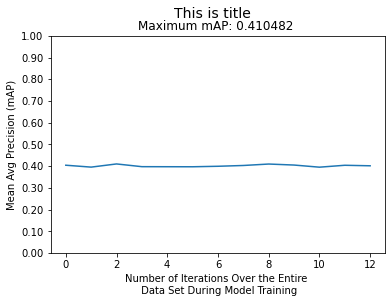

In [28]:
plot_object_detection_log(model_path, title="This is title")

In [15]:
predictor = get_predictor(endpoint_name)

In [16]:
def read_wavfile(wav_name, normalize=True, verbose=False):
    file_name = f"{wav_name}_processed.wav"
    bucket_path = f"wav-files/decimated_files/{file_name}"
    download_bucket.download_file(bucket_path, file_name)
    if verbose:
        print("Reading {}".format(file_name))
    sr, data = wavfile.read(file_name)
    os.remove(file_name)
    if verbose:
        print("{} samples at {} samples/sec --> {} seconds".format(data.shape[0], sr, data.shape[0]/sr))

    if normalize:
        data = data.astype(float)
        data = data - data.min()
        data = data / data.max()
        data = data - 0.5
    return sr, data


def read_annotations(fname, verbose=False):
    annotators = ['AS.txt', 'AW.txt', 'JW.txt', 'MS.txt', 'SS.txt']
    
    
    for annotator in annotators:
        file_name = f"{fname}-{annotator}"
#         file_name = f"{fname}-AW.txt"
        bucket_path = f"selection-tables/{file_name}"
        try:
            bucket.download_file(bucket_path, file_name)
            break
        except Exception:
                continue
    
    annotations = pd.read_csv(file_name, sep="\t")
    try:
        annotations = annotations.loc[annotations["Species"] == "hb"]
    except Exception as e:
        pass
    
    try:
        annotations = annotations.loc[annotations["Spcies"] == "hb"]
    except Exception as e:
        pass
    
    if verbose:
        print("Read {} annotations from {}".format(len(annotations), fname))
        print("Columns:", ",".join([" {} ({})".format(c, type(c)) for c in annotations.columns]))
    os.remove(file_name)
    return annotations



def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] <= bb1['x2']
    assert bb1['y1'] <= bb1['y2']
    assert bb2['x1'] <= bb2['x2']
    assert bb2['y1'] <= bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
  

In [17]:
def get_hand_annotated_boxes_spec(file_name):
    with open("val.lst", "r") as f:
        for line in f:
            filePath = line.split("\t")[-1]
            fileName = filePath.split("/")[-1].strip()
            
            if file_name == fileName:
                annots = [float(el) for el in line.split("\t")[3:-1]]
                temp = [annots[i+1:i+5] for i in range(0, len(annots), 5)]
                return temp

In [18]:
def calculate_precision_recall(predicted_boxes, hand_annotated_boxes, threshold=0.15, absThresh=0.2):
    truePositives = 0
    falsePositives = 0
    
    if hand_annotated_boxes is None:
        truePositives = 0
        falsePositives = len(predicted_boxes)
        falseNegatives = 0
        return truePositives, falsePositives, falseNegatives, predicted_boxes, 0
    
    notVisited = [True for box in hand_annotated_boxes]
    numberHandAnnotated = len(hand_annotated_boxes)

    
    maxIouScores = []
    boxes = []
    flags = [False for box in predicted_boxes]
    
    predicted_boxes = [predicted_boxes[i] for i in range(len(predicted_boxes)) if predicted_boxes[i][1] >= absThresh]
    
    if len(predicted_boxes) == 0:
        truePositives = 0
        falsePositives = 0
        falseNegatives = numberHandAnnotated
        return truePositives, falsePositives, falseNegatives, predicted_boxes, numberHandAnnotated
    for i, predBox in enumerate(predicted_boxes):
        klass, score, x0, y0, x1, y1 = predBox

        maxIou = None
        for j, handAnnot in enumerate(hand_annotated_boxes):
            xmin, ymin, xmax, ymax = handAnnot
            predictedBox = {"x1": x0, "x2": x1, "y1": y0,"y2": y1}
            groundTruth = {"x1": xmin, "x2": xmax,"y1": ymin,"y2": ymax}
            iouScore = get_iou(predictedBox, groundTruth)
            
            if maxIou is None or iouScore > maxIou:
                maxIou = iouScore
        maxIouScores.append(maxIou)
        
    for i, predBox in enumerate(predicted_boxes):
        klass, score, x0, y0, x1, y1 = predBox
        count = False       
        for j, handAnnot in enumerate(hand_annotated_boxes):
            xmin, ymin, xmax, ymax = handAnnot           
            predictedBox = {"x1": x0, "x2": x1, "y1": y0,"y2": y1}
            groundTruth = {"x1": xmin, "x2": xmax,"y1": ymin,"y2": ymax}
            
            iouScore = get_iou(predictedBox, groundTruth)
            if iouScore > threshold:
                count = True
                notVisited[j] = False

        if count:
            truePositives += 1
        else:
            falsePositives += 1
    falseNegatives = sum(notVisited)
    return truePositives, falsePositives, falseNegatives, predicted_boxes, numberHandAnnotated

The function below gets the hand annotated boxes and model predicted boxes for a given spectrogram. This spectrogram needs to exist in the data directory. If it doesn't, use the ConvertWavFiles file to populate the data directory with spectrograms. 

In [18]:
#filename is the name of one of the spectrograms found in the data directory - if there are no spectrograms in there - use ConvertWaveFiles to generate some
filename = "671658014.181008033412-145.png"
hand_annotated_boxes = get_hand_annotated_boxes_spec(filename)

predictions = get_model_bounding_boxes(f"data/{filename}")
calculate_precision_recall(predictions, hand_annotated_boxes)


NameError: name 'get_hand_annotated_boxes_spec' is not defined

In [ ]:
files = glob.glob('data/*.png')

def get_metrics(files, cthresholds):
    for cthresh in cthresholds:
        totalTp = 0
        totalFp = 0
        totalFn = 0
        groundtruth = 0
        print(f"Confidence Threshold: {cthresh}")
        for file in sorted(files):
            filename = file.split("/")[-1]
            hand_annotated_boxes = get_hand_annotated_boxes_spec(filename)
            predictions = get_model_bounding_boxes(f"data/{filename}")
            truePositives, falsePositives, falseNegatives, predicted_boxes, gt = calculate_precision_recall(predictions, hand_annotated_boxes, absThresh=cthresh)
            totalTp += truePositives
            totalFp += falsePositives
            totalFn += falseNegatives
            groundtruth += gt
        print(f"True Positives: {totalTp}, False Positives: {totalFp}, False Negatives: {totalFn}")
        print(f"Recall: {(groundtruth-totalFn)/groundtruth}")
        print(f"Precision: {totalTp/(totalTp + totalFp)}")
        print()


cthresholds = [0.225, 0.228]
get_metrics(files, cthresholds)

In [47]:
totalTp, totalFp, totalFn

print("Recall:")
print((groundtruth-totalFn)/groundtruth)
print("Precision:")
print(totalTp/(totalTp + totalFp))

Recall:
0.8411686586985392
Precision:
0.4968666069829902


In [17]:
pctl = 90
toTake = len(predictions)*(1-pctl/100)
predicted_boxes = predictions[:int(toTake)]
plot_image_with_boxes(f"data/{filename}", hand_annotated_boxes=hand_annotated_boxes, model_predicted_boxes=predicted_boxes,
                   threshold=0,pctl=pctl)

NameError: name 'predictions' is not defined

Number of detections: 10


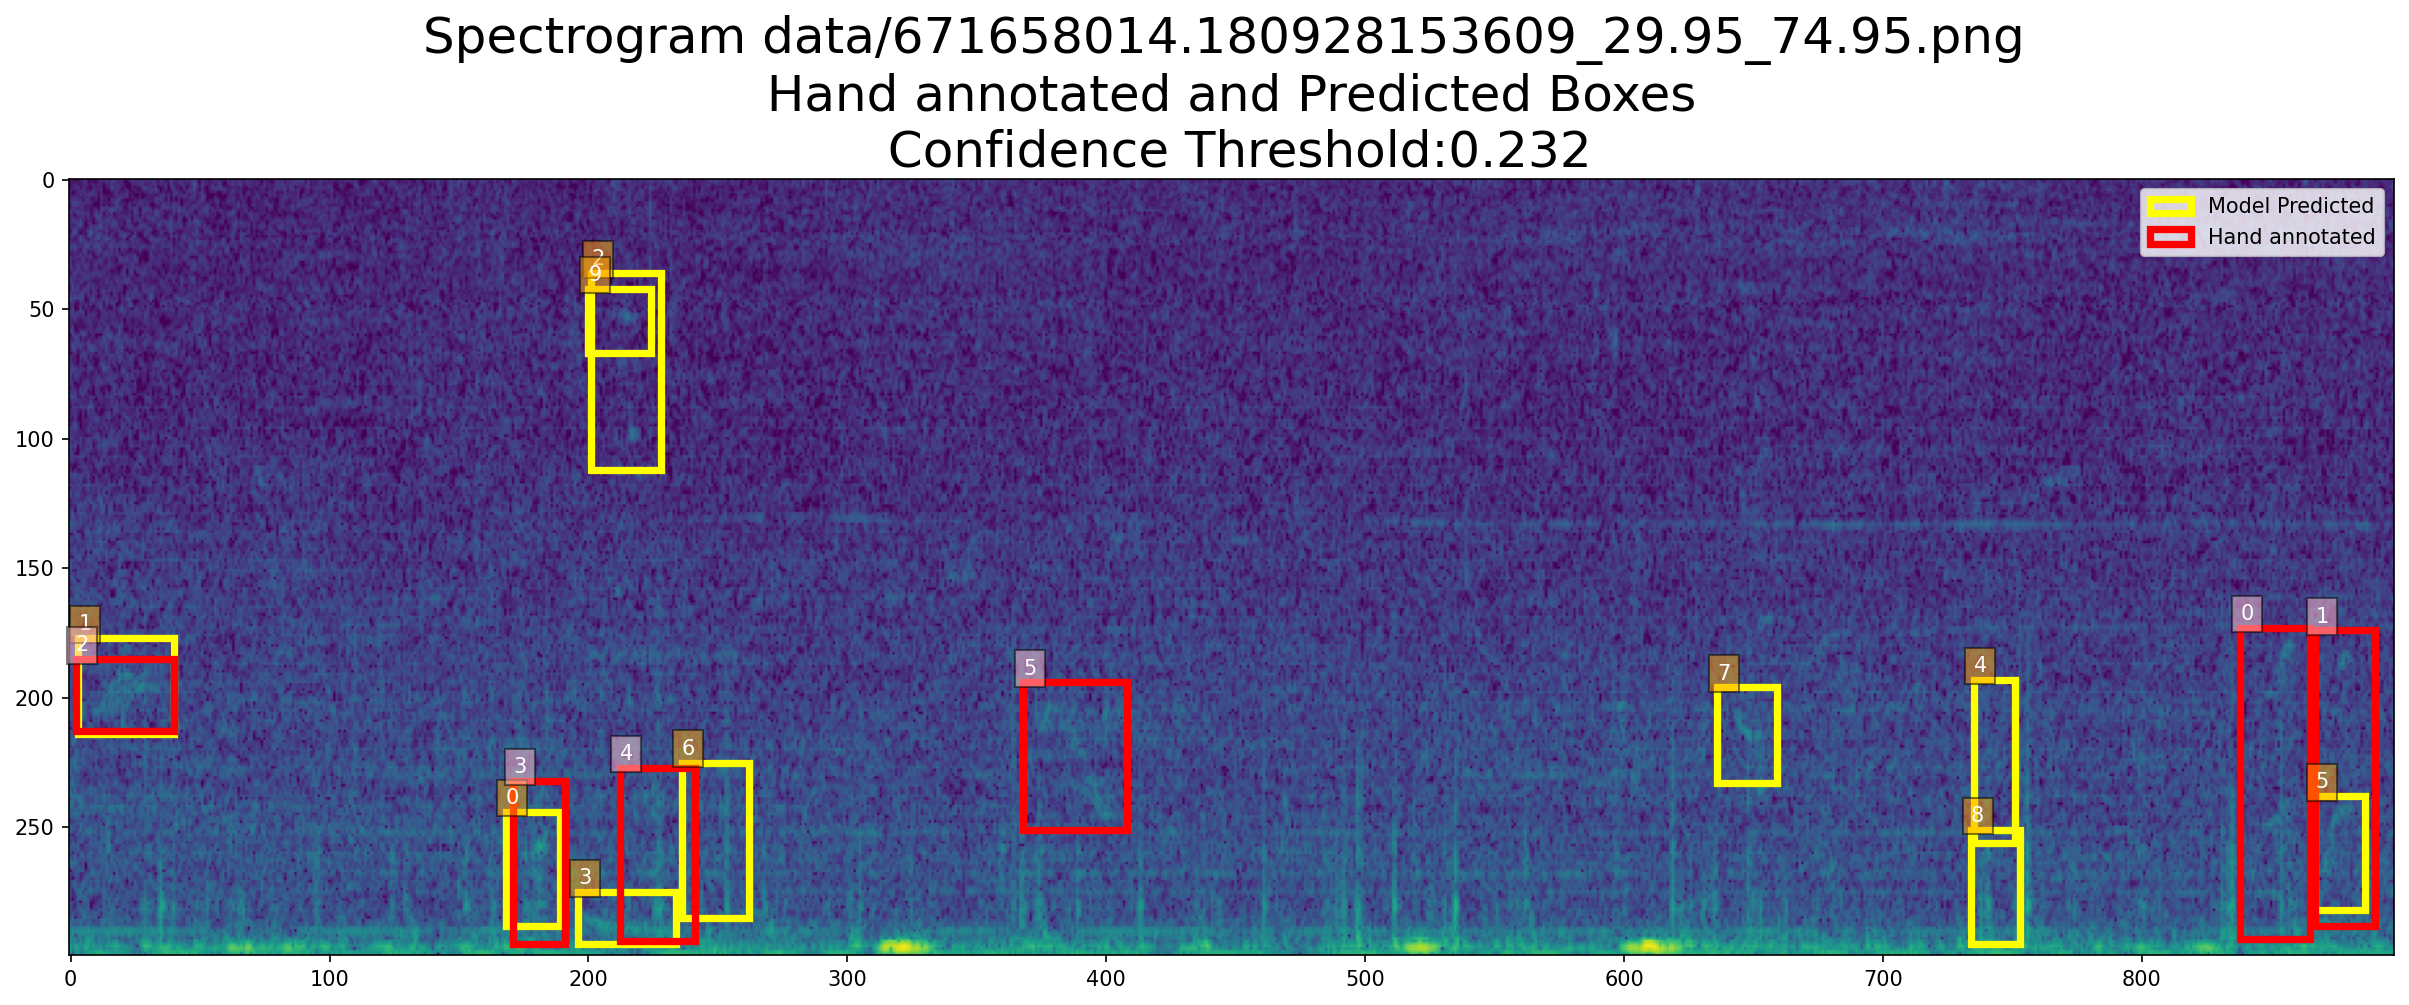

In [111]:
# predictions = predictions["prediction"]
n = 10
temp = predictions[:n]+predictions[n+1:]
plot_image_with_boxes(f"data/{filename}", hand_annotated_boxes=hand_annotated_boxes[:6] + hand_annotated_boxes[7:], model_predicted_boxes=temp, threshold=0.232)

Number of detections: 18


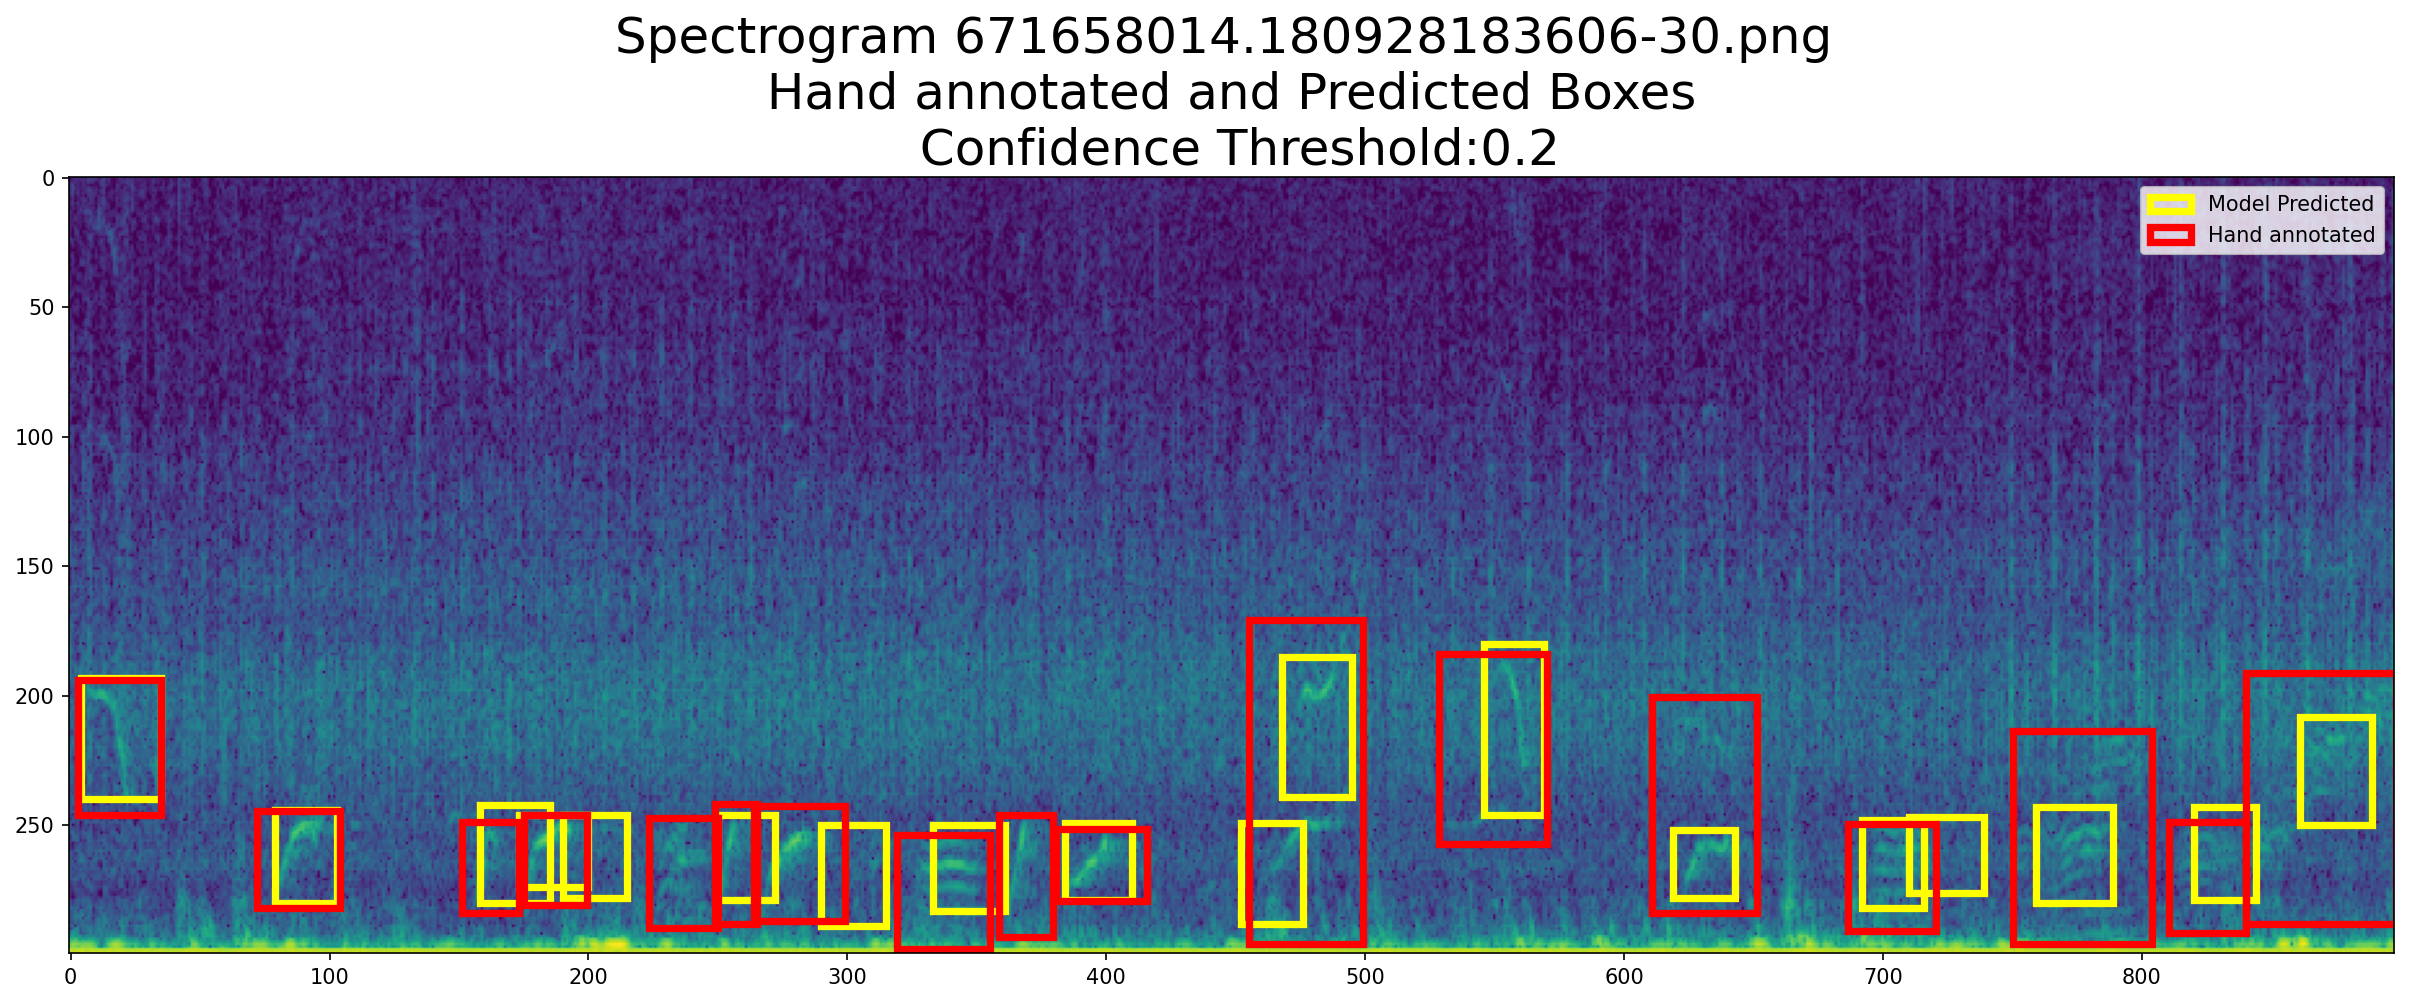

In [244]:
plot_image_with_boxes(spectrogram_name, hand_annotated_boxes, predicted_boxes, threshold=0.2)

In [26]:
#When done
delete_model(model)